In [1]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import fft, arange, fftpack

from utils.smart_utils import get_dir_path, tensor_to_pandas, load_hdf5_file
from utils.smart_utils import get_array_filenames, split_on_classes
from preprocessing.process_data import get_data

from utils.plot_utils import plot_spectra_1axis, plot_spectra_3axis
from utils.plot_utils import plot_3axis_raw_signal_1, plot_3axis_raw_signal_compare
from utils.plot_utils import single_file_plots, load_file_to_pandas

from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation
from sklearn.model_selection import cross_val_predict
from ReliefF import ReliefF

# %matplotlib inline 

/home/jogi/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
files = get_array_filenames('20160921', device='futurocube', game='roadrunner', sequence=1, file_ext='csv')
freq = 20   # 20 Hz
t_cufoff = 0*freq
exp_labels = []

for filename in files:
    labels = filename[filename.index('[') + 1:filename.index(']')] # .split(':')
    
    r_signal = (load_file_to_pandas("futurocube", "roadrunner", filename, abs_path=True)
         ).as_matrix()

    single_file_plots(r_signal, freq, lowcut=2, highcut=0.1, f_type='lowhigh', b_order=5, 
                      plot_type=3, width=20, height=5, p_legend=True,
                      add_to_title=labels + " / ",
                      apply_w_func=False, skip_dc=True, use_raw_sig=True, use_mag=True)


In [4]:
for filename in files:
    labels = filename[filename.index('[') + 1:filename.index(']')] # .split(':')
    
    r_signal = (load_file_to_pandas("futurocube", "roadrunner", filename, abs_path=True)
         ).as_matrix()
    # signal_fraction = r_signal[t_cufoff:t_cufoff+360, :]
    # print(signal_fraction.shape)
    single_file_plots(r_signal, freq, lowcut=0.5, highcut=0.1, f_type='lowhigh', b_order=5, 
                      plot_type=2, width=15, height=5, p_legend=True,
                      add_to_title=labels + " / ",
                      apply_w_func=False, skip_dc=True, use_raw_sig=True)

In [20]:
train_data, train_labels, dta_dict = get_data('20160921', force=False, apply_window_func=False, calc_mag=True,
                                              extra_label="20hz_nofilter_45_8_1", optimal_w_size=False)
                                     
                # calc_mag=True, f_type="lowhigh", lowcut=2, highcut=0.1, b_order=5)
        
# for cross validation train data has to have 2 dim tensor
train_data_r = np.reshape(train_data, (train_data.shape[0], train_data.shape[1] * train_data.shape[2]))
# for cross validation train labels has to have 1 dim tensor
train_labels_r = np.reshape(train_labels, (train_labels.shape[0]))
print(train_data_r.shape)
print(train_labels_r.shape)

INFO - Used data label 20160921_futurocube_roadrunner_20hz_nofilter_45_8_1
INFO Loading matrices from h5 file /home/jogi/git/repository/smart_play_set/data/futurocube/roadrunner/20160921_futurocube_roadrunner_20hz_nofilter_45_8_1.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data'])
INFO - Loading data description from json.
(45, 8)
(45,)


In [21]:
# train_data, train_labels, dta_dict
print(dta_dict)

{u'window_size': 800, u'num_of_files': 9, u'features': [u'min', u'max', u'mean', u'std', u'median', u'dc', u'energy', u'power_spec_entropy'], u'MEAN_FILE_LENGTH': 2400, u'LABELS': [u'ID', u'CLASS', u'AGE', u'SEX', u'HANDED'], u'id_attributes': [{u'CLASS': u'0', u'AGE': u'Age8', u'ID': u'ID6', u'HANDED': u'1', u'SEX': u'0'}, {u'CLASS': u'1', u'AGE': u'Age7', u'ID': u'ID2', u'HANDED': u'0', u'SEX': u'1'}, {u'CLASS': u'0', u'AGE': u'Age7', u'ID': u'ID7', u'HANDED': u'1', u'SEX': u'0'}, {u'CLASS': u'1', u'AGE': u'Age8', u'ID': u'ID3', u'HANDED': u'0', u'SEX': u'1'}, {u'CLASS': u'0', u'AGE': u'Age7', u'ID': u'ID9', u'HANDED': u'0', u'SEX': u'0'}, {u'CLASS': u'1', u'AGE': u'Age7', u'ID': u'ID1', u'HANDED': u'1', u'SEX': u'1'}, {u'CLASS': u'1', u'AGE': u'Age7', u'ID': u'ID8', u'HANDED': u'1', u'SEX': u'0'}, {u'CLASS': u'0', u'AGE': u'Age7', u'ID': u'ID4', u'HANDED': u'1', u'SEX': u'0'}, {u'CLASS': u'1', u'AGE': u'Age7', u'ID': u'ID5', u'HANDED': u'1', u'SEX': u'1'}], u'filter_specs': [8, 0.5,

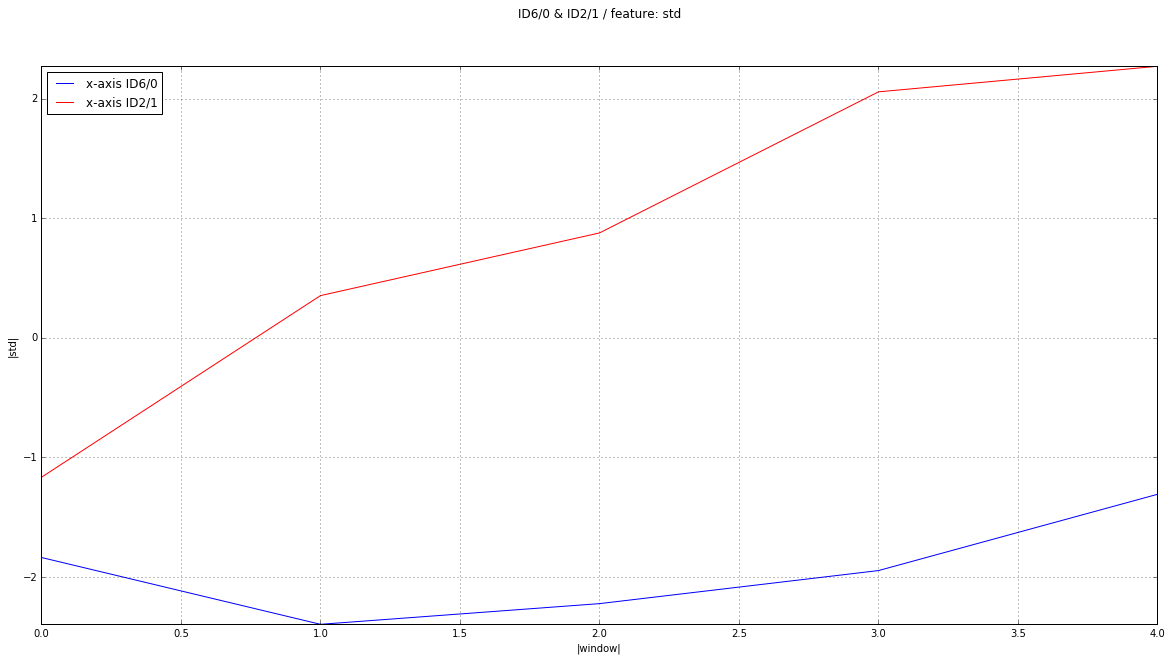

In [82]:
def plot_one_feature(data1, label1, f_index, features, data2=None, label2="", width=20, height=10, 
                           p_legend=False, xyz_axis=True):
    
    feature = features[f_index]
    data1 = np.reshape(data1[:, f_index, :], (data1.shape[0], data1.shape[2]))
    if data2 is not None:
        data2 = np.reshape(data2[:, f_index, :], (data2.shape[0], data2.shape[2]))
        p_title = label1 + " & " + label2 + " / feature: " + feature
    else:
        p_title = label1 + " / feature: " + feature
        
    t = np.arange(data1.shape[0])
    y_label = "|" + feature + "|"
    x_label = "|window|"
    
    plt.figure(figsize=(width, height))
    if xyz_axis:
        ax1 = plt.subplot(3, 1, 1)
    else:
        ax1 = plt.subplot(1, 1, 1)
        
    plt.title(p_title, y=1.08)

    plt.plot(t, data1[:, 0], label='x-axis ' + label1)
    if data2 is not None:
        plt.plot(t, data2[:, 0], label='x-axis ' + label2, color='r')
    plt.xlabel(x_label)
    plt.grid(True)
    plt.ylabel(y_label)
    if p_legend:
        plt.legend(loc="best")
    
    if xyz_axis:
        plt.subplot(3, 1, 2, sharex=ax1)
        plt.plot(t, data1[:, 1], label='y-axis ' + label1)
        if data2 is not None:
            plt.plot(t, data2[:, 1], label='y-axis ' + label2, color='r')
        plt.xlabel(x_label)
        plt.grid(True)
        plt.ylabel(y_label)
        if p_legend:
            plt.legend(loc="best")

        plt.subplot(3, 1, 3, sharex=ax1)
        plt.plot(t, data1[:, 2], label='z-axis ' + label1)
        if data2 is not None:
            plt.plot(t, data2[:, 2], label='z-axis ' + label2, color='r')
        plt.xlabel(x_label)
        plt.grid(True)
        plt.ylabel(y_label)
        if p_legend:
            plt.legend(loc="best")

    plt.axis('tight')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


num_of_windows = int(dta_dict_f["num_of_windows"])
feature_list = dta_dict_f["features"]
label_dicts = dta_dict_f["id_attributes"]
dta1 = train_data_f[0:num_of_windows, :, :]
label1 = label_dicts[0]["ID"] + "/" + label_dicts[0]["CLASS"] 
label2 = label_dicts[1]["ID"] + "/" + label_dicts[1]["CLASS"]
dta2 = train_data_f[num_of_windows:num_of_windows+num_of_windows, :, :]
plot_one_feature(dta1, label1, data2=dta2, label2=label2, features=feature_list, f_index=3,  
                       p_legend=True, xyz_axis=False)

In [ ]:
plot_one_feature(dta1, label1, data2=dta2, label2=label2, features=feature_list, f_index=6,  
                       p_legend=True, xyz_axis=True)

In [182]:
train_data_f, train_labels_f, dta_dict_f = get_data('20160921', force=False, apply_window_func=True, calc_mag=True,
                                              extra_label="20hz_1axis_filj", optimal_w_size=False,
                                                   f_type='lowhigh', lowcut=1.95, highcut=0.1, b_order=5)

# for cross validation train data has to have 2 dim tensor
train_data_f_r = np.reshape(train_data_f, (train_data_f.shape[0], train_data_f.shape[1] * train_data_f.shape[2]))
# for cross validation train labels has to have 1 dim tensor
train_labels_f_r = np.reshape(train_labels_f, (train_data_f.shape[0]))
print(train_data_f_r.shape)
print(train_labels_f_r.shape)
print(dta_dict_f["features"])
print(dta_dict_f["filter"])
print(dta_dict_f["filter_specs"])
print(dta_dict_f["window_func"])
num_of_features = len(dta_dict_f["features"])

INFO - Used data label 20160921_futurocube_roadrunner_20hz_1axis_filj
INFO - Need to process raw data...
-------------------------------------------------------------------------
INFO - Running feature calculation with the following parameter settings:
-------------------------------------------------------------------------
Game device *** futurocube  roadrunner ***
Assuming sample frequency of device: 20
Cutting off the first samples: 0
Calculated window size for feature extraction: 800
Length of window is approx 40.00 secs
Restrict # of windows per file to 5 = 2400 seconds

Compute features based on signal magnitude True
IMPORTANT - Applying filtering - Butterworth type lowhigh
Filter details lowcut/highcut/order 1.95/0.1/5

IMPORTANT - Applying window function - Hamming: True

List of features
['min', 'max', 'mean', 'std', 'median', 'dc', 'energy', 'power_spec_entropy']
---------------------------------------------------------------------------

INFO - Loading accelerometer 9 files

In [15]:
# feature selection based on reliefF algorithm
fs = ReliefF(n_neighbors=10, n_features_to_keep=8)
X_train = fs.fit_transform(train_data_r, train_labels_r)
X_train = fs.transform(train_data_r)
f_list = [dta_dict['features'][i] for i in fs.top_features]
print("top feature list: ", f_list)

top feature list:  [u'max', u'min', u'power_spec_entropy', u'energy', u'dc', u'median', u'std', u'mean']


In [65]:
# feature selection based on reliefF algorithm
fs = ReliefF(n_neighbors=10, n_features_to_keep=24)
X_train_f = fs.fit_transform(train_data_f_r, train_labels_f_r)
X_train_f = fs.transform(train_data_f_r)
print(fs.feature_scores)
print(fs.top_features)
# f_list = [dta_dict['features'][i] for i in fs.top_features]
# print("top feature list: ", f_list)

[-70. -62. -86. -86. -86. -86. -86. -86.]
[1 0 7 6 5 4 3 2]


In [62]:

gnb = GaussianNB()
# y_pred = gnb.fit(train_data_r, train_labels_r).predict(train_data_r)
# print("Number of mislabeled points out of a total %d points : %d" % 
#                       (train_data_r.shape[0],(train_labels_r != y_pred).sum()))

scores = cross_validation.cross_val_score(gnb, X_train_f, train_labels_f_r, cv=8)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.63 (+/- 0.40)


In [71]:
# feature selection based on reliefF algorithm
fs = ReliefF(n_neighbors=10, n_features_to_keep=2)
X_train_1 = fs.fit_transform(train_data_r, train_labels_r)
X_train_1 = fs.transform(train_data_r)
f_list = [dta_dict['features'][i] for i in fs.top_features]
print("top feature list: ", f_list)

clf = svm.SVC(kernel='rbf', C=1)
scores = cross_validation.cross_val_score(clf, X_train_1, train_labels_r, cv=12)
# predicted = cross_val_predict(clf, X_train_f, train_labels_f_r, cv=8)
# print(predicted)
# scores = accuracy_score(train_labels_r, predicted) 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


top feature list:  [u'max', u'min', u'power_spec_entropy', u'energy', u'dc', u'median', u'std', u'mean']
Accuracy: 0.72 (+/- 0.51)


In [214]:
print(train_data_f_r[np.ix_([0,2,4])])
array = None
for i in np.arange(0, train_data_f_r.shape[0], 5):
    if i == 0:
        array = train_data_f_r[np.ix_([i,i+2,i+4])]
    else:
        array = np.concatenate((array, train_data_f_r[np.ix_([i,i+2,i+4])]), axis=0)
print(array.shape)

[[ 0.64109633 -0.71850916 -0.86421426 -1.72253498 -0.35207944  0.6996839
  -0.6931226  -1.26914972]
 [ 1.29022892 -0.7610547  -0.99553164 -1.79323413 -0.05968138 -0.46886294
   0.12989007  0.793366  ]
 [ 0.55172374 -0.41811639 -0.26389167 -1.20821094  0.71688717 -0.81225287
  -0.70977005  1.35595555]]
(27, 8)


In [221]:
for d in np.arange(8):
    idx = d+1
    fs = ReliefF(n_neighbors=10, n_features_to_keep=idx)
    X_train_2 = fs.fit_transform(train_data_f_r, train_labels_f_r)
    X_train_2 = fs.transform(train_data_f_r)
    f_list = [dta_dict['features'][i] for i in fs.top_features]
    print("--------------------------------------------------------------")
    print("Keep %d, top feature list: %s" % (idx, ', '.join(f_list[:idx])))

    array1 = None
    new_labels = None
    for i in np.arange(0, X_train_2.shape[0], 5):
        if i == 0:
            array1 = X_train_2[np.ix_([i,i+2,i+4])]
            new_labels = train_labels_f_r[np.ix_([i,i+2,i+4])]
        else:
            array1 = np.concatenate((array1, X_train_2[np.ix_([i,i+2,i+4])]), axis=0)
            new_labels = np.concatenate((new_labels, train_labels_f_r[np.ix_([i,i+2,i+4])]), axis=0)
    
    X_train_2 = array1[:]
    print(X_train_2.shape, new_labels.shape)
    
    clf = svm.SVC(kernel='rbf', C=1)
    scores_svm = cross_validation.cross_val_score(clf, X_train_2, new_labels, cv=12)
    # predicted = cross_val_predict(clf, X_train_f, train_labels_f_r, cv=8)
    # print(predicted)
    # scores = accuracy_score(train_labels_r, predicted) 
    print("SVM - Accuracy: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
    
    rfc = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
    scores_rfc = cross_validation.cross_val_score(clf, X_train_2, new_labels, cv=12)
    print("rfc - Accuracy: %0.2f (+/- %0.2f)" % (scores_rfc.mean(), scores_rfc.std() * 2))
    
    xgb = XGBClassifier(learning_rate=0.1, n_estimators=300, max_depth=5, min_child_weight=2, gamma=0.1,
                         subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4,
                         scale_pos_weight=1, seed=27)
    scores_xgb = cross_validation.cross_val_score(clf, X_train_2, new_labels, cv=12)
    print("xgb - Accuracy: %0.2f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std() * 2))
    
    gnb = GaussianNB()
    scores_gnb = cross_validation.cross_val_score(gnb, X_train_2, new_labels, cv=12)
    print("gnb - Accuracy: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() * 2))

--------------------------------------------------------------
Keep 1, top feature list: max
(27, 1) (27,)
SVM - Accuracy: 0.57 (+/- 0.50)
rfc - Accuracy: 0.57 (+/- 0.50)
xgb - Accuracy: 0.57 (+/- 0.50)
gnb - Accuracy: 0.46 (+/- 0.43)
--------------------------------------------------------------
Keep 2, top feature list: max, min
(27, 2) (27,)
SVM - Accuracy: 0.76 (+/- 0.50)
rfc - Accuracy: 0.76 (+/- 0.50)
xgb - Accuracy: 0.76 (+/- 0.50)
gnb - Accuracy: 0.61 (+/- 0.48)
--------------------------------------------------------------
Keep 3, top feature list: max, min, power_spec_entropy
(27, 3) (27,)
SVM - Accuracy: 0.68 (+/- 0.48)
rfc - Accuracy: 0.68 (+/- 0.48)
xgb - Accuracy: 0.68 (+/- 0.48)
gnb - Accuracy: 0.58 (+/- 0.50)
--------------------------------------------------------------
Keep 4, top feature list: max, min, power_spec_entropy, energy
(27, 4) (27,)
SVM - Accuracy: 0.86 (+/- 0.40)
rfc - Accuracy: 0.86 (+/- 0.40)
xgb - Accuracy: 0.86 (+/- 0.40)
gnb - Accuracy: 0.75 (+/- 0.4

In [28]:
clf = tree.DecisionTreeClassifier()
scores = cross_validation.cross_val_score(clf, X_train_f, train_labels_f_r, cv=8)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.38)


In [29]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=1, random_state=0)
scores = cross_validation.cross_val_score(clf, X_train_f, train_labels_f_r, cv=8)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.76 (+/- 0.31)


In [25]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=700, max_depth=5, min_child_weight=2, gamma=0,
                         subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4,
                         scale_pos_weight=1, seed=27)
scores = cross_validation.cross_val_score(clf, X_train_f, train_labels_f_r, cv=8)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.78 (+/- 0.23)


In [17]:
def plot_one_feature_v2(data, num_of_windows, n_files, l_dict, features, f_index=-1, width=20, height=10, 
                           p_legend=False):
    
    
    feature = features[f_index]
    t = np.arange(num_of_windows)
    x_label = "|window|"
    
    if f_index==-1:
        f_range = np.arange(len(features))
        if height < 40:
            height = 40
    else:
        f_range = [f_index]
        
    plt.figure(figsize=(width, height))
    plt.gca().set_autoscale_on(False)
    plt.xlabel(x_label)
    
    dta_0 = None
    dta_1 = None
    first_plot = True
        
    for i, f_idx in enumerate(f_range):
        feature = features[f_idx]
        y_label = "|" + feature + "|"
        ax1 = plt.subplot(len(f_range), 1, i+1)
        plt.ylabel(y_label)
        p_title = "All %d ID's " % n_files + " / feature: " +  feature
        plt.title(p_title, y=1.08)
        
        for idx in np.arange(n_files):
            offset = int(idx*num_of_windows)
            dta = np.reshape(data[offset:offset+num_of_windows, f_index, :], (num_of_windows, data.shape[2]))

            label = "class %s" % l_dict[idx]["CLASS"]
            if l_dict[idx]["CLASS"] == '0':
                p_color = 'g'
                cls1, = plt.plot(t, dta[:, 0], color=p_color, marker='o', linestyle='None', markersize=12, 
                            label=label)
            else:
                p_color = 'r'
                cls2, = plt.plot(t, dta[:, 0], color=p_color, marker='o', linestyle='None', markersize=12,
                            label=label)
            
            plt.xlim([-0.5,4.5])
            plt.ylim([-3,3])
        if p_legend and first_plot:
            ax1.legend(handles=[cls1, cls2], loc="best")
        else:
            first_plot = False

        # plt.axis('tight')
        # plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.show()

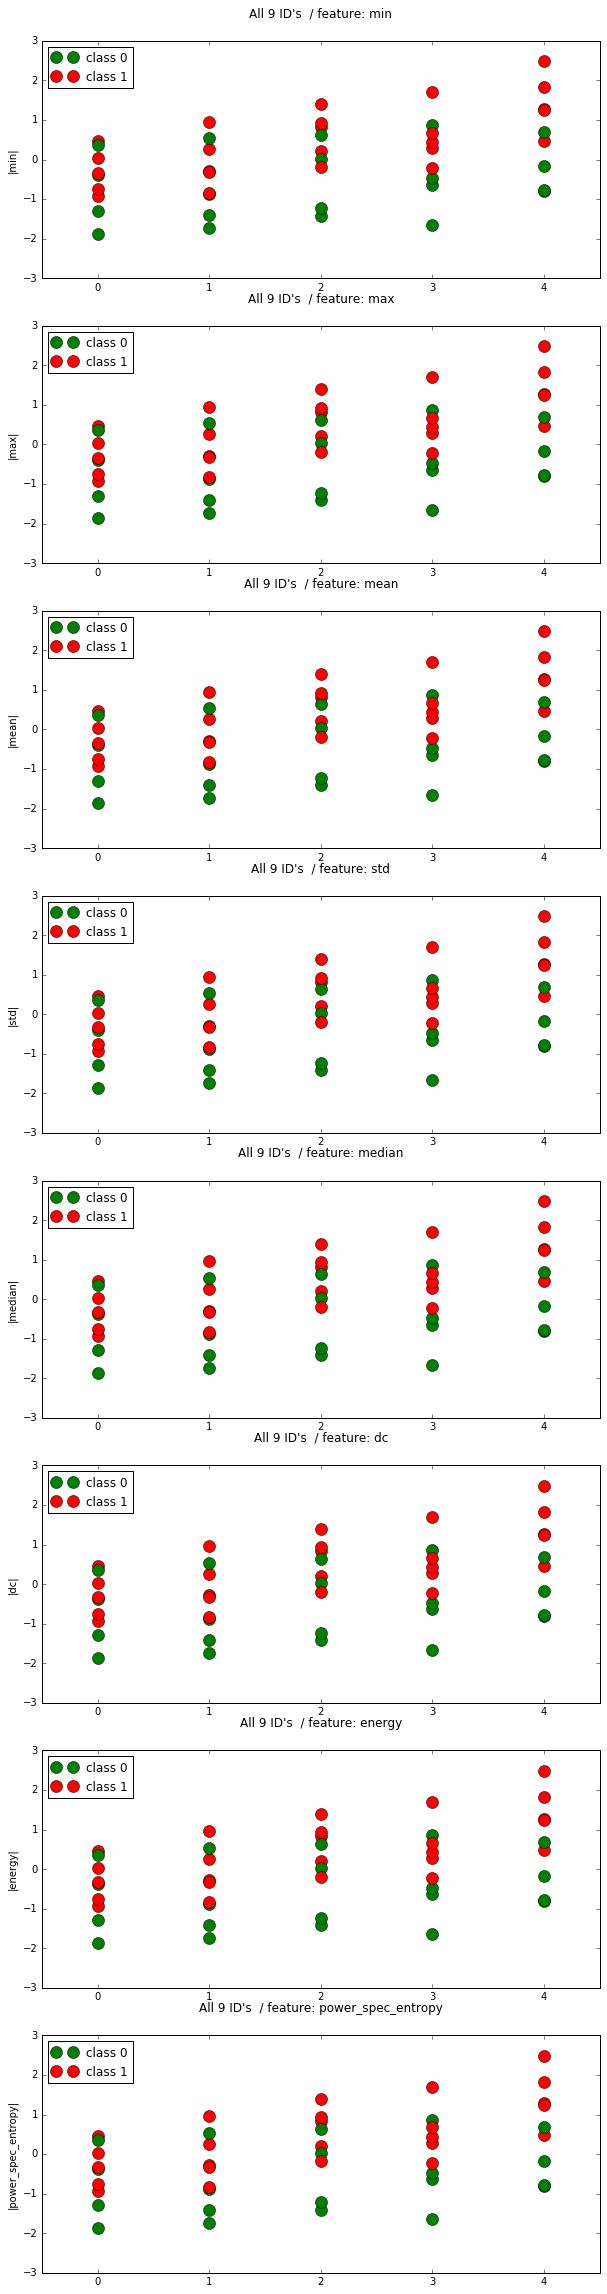

In [18]:
num_of_files = int(dta_dict["num_of_files"])
num_of_windows = int(dta_dict["num_of_windows"])
feature_list = dta_dict["features"]
label_dicts = dta_dict["id_attributes"]

plot_one_feature_v2(train_data, num_of_windows, 9, label_dicts, features=feature_list, f_index=-1,  
                       p_legend=True, width=10, height=10)

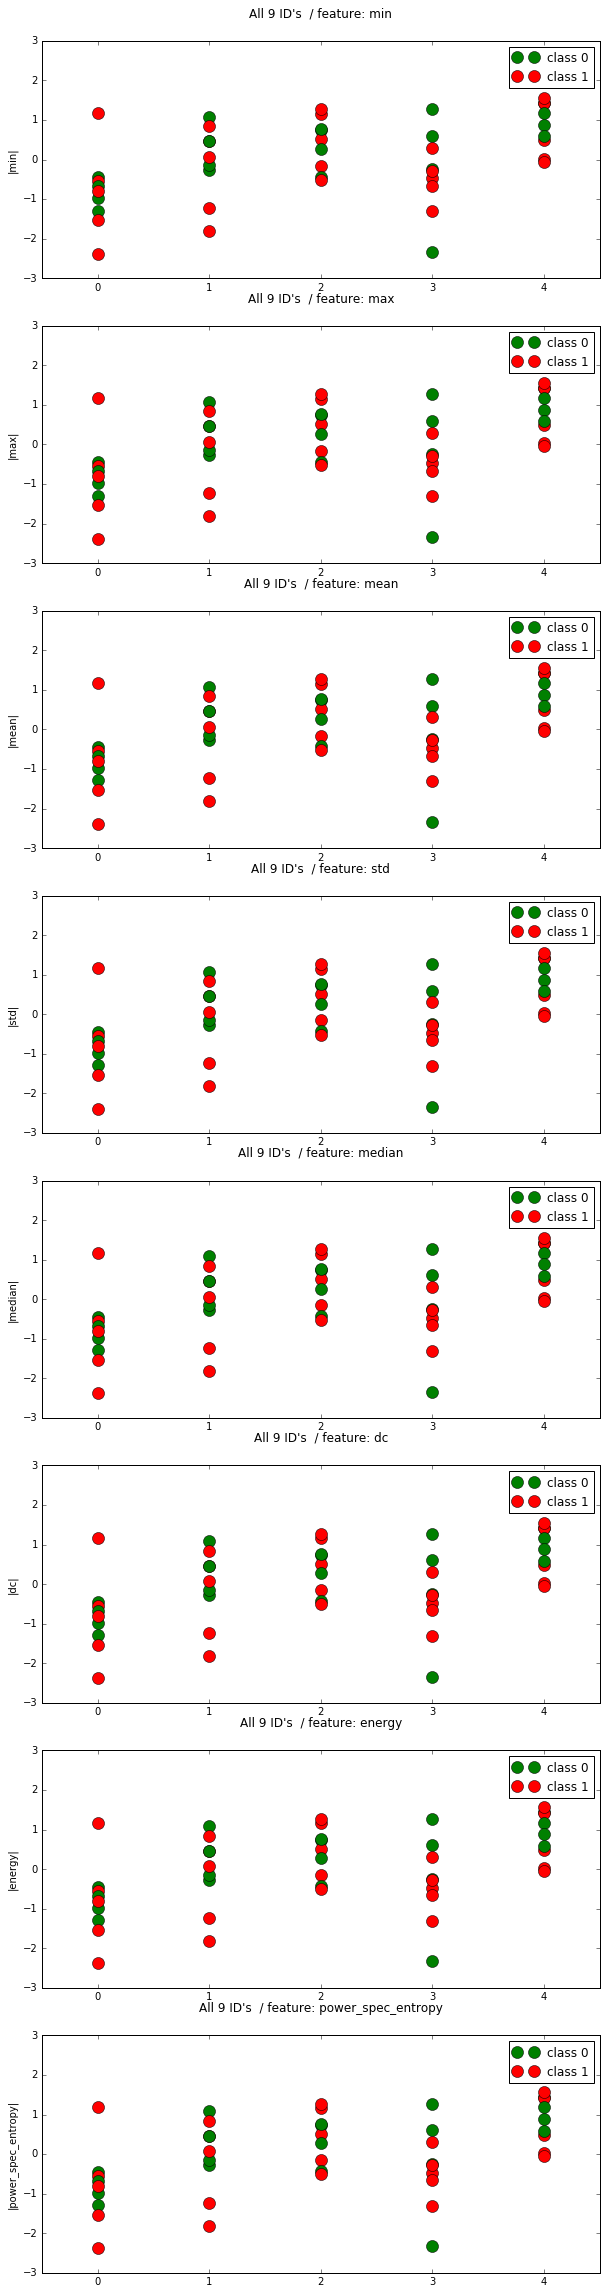

In [30]:
num_of_files = int(dta_dict_f["num_of_files"])
num_of_windows = int(dta_dict_f["num_of_windows"])
feature_list = dta_dict_f["features"]
label_dicts = dta_dict_f["id_attributes"]

plot_one_feature_v2(train_data_f, num_of_windows, 9, label_dicts, features=feature_list, f_index=-1,  
                       p_legend=True, width=10, height=10)

In [11]:
def plot_one_feature_v3(dta1, dta2, num_of_windows, labels, features, f_index=-1, width=20, height=10, 
                           p_legend=False):
    
    
    if f_index==-1:
        f_range = np.arange(len(features))
        if height < 40:
            height = 40
    else:
        f_range = [f_index]
        
    t = np.arange(num_of_windows)
    x_label = "|window|"
    
    plt.figure(figsize=(width, height))

    plt.gca().set_autoscale_on(False)
    plt.xlabel(x_label)
    label1 = "Class %d" % labels[0]
    label2 = "Class %d" % labels[1]
    dta1_dim1 = int(dta1.shape[0] / num_of_windows)
    dta2_dim1 = int(dta2.shape[0] / num_of_windows)
    first_plot = True
    
    for i, f_idx in enumerate(f_range):
        feature = features[f_idx]
        y_label = "|" + feature + "|"
        ax1 = plt.subplot(len(f_range), 1, i+1)
        plt.ylabel(y_label)
        p_title = "Average per class" + " / feature: " + feature   
        plt.title(p_title, y=1.08)
        for idx in np.arange(num_of_windows):

            dta1_m = np.reshape(dta1[idx::num_of_windows, f_index, :], (dta1_dim1, dta1.shape[2]))
            dta2_m = np.reshape(dta2[idx::num_of_windows, f_index, :], (dta2_dim1, dta2.shape[2]))  
            dta1_err = dta1_m.std(axis=0)
            dta2_err = dta2_m.std(axis=0)
            dta1_m = dta1_m.mean(axis=0)
            dta2_m = dta2_m.mean(axis=0)

            cls1, = plt.plot(t[idx], dta1_m, color='g', marker='o', linestyle='None', markersize=12, label=label1)
            plt.errorbar(t[idx], dta1_m, yerr=dta1_err, fmt='g')
            cls2, = plt.plot(t[idx], dta2_m, color='r', marker='D', linestyle='None', 
                                 markersize=12, label=label2)
            plt.errorbar(t[idx], dta2_m, yerr=dta2_err, fmt='r')
            plt.xlim([-0.5,4.5])
            plt.ylim([-3,3])
        
        if p_legend:
            plt.legend(handles=[cls1, cls2], loc="best")

    
    # plt.axis('tight')
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

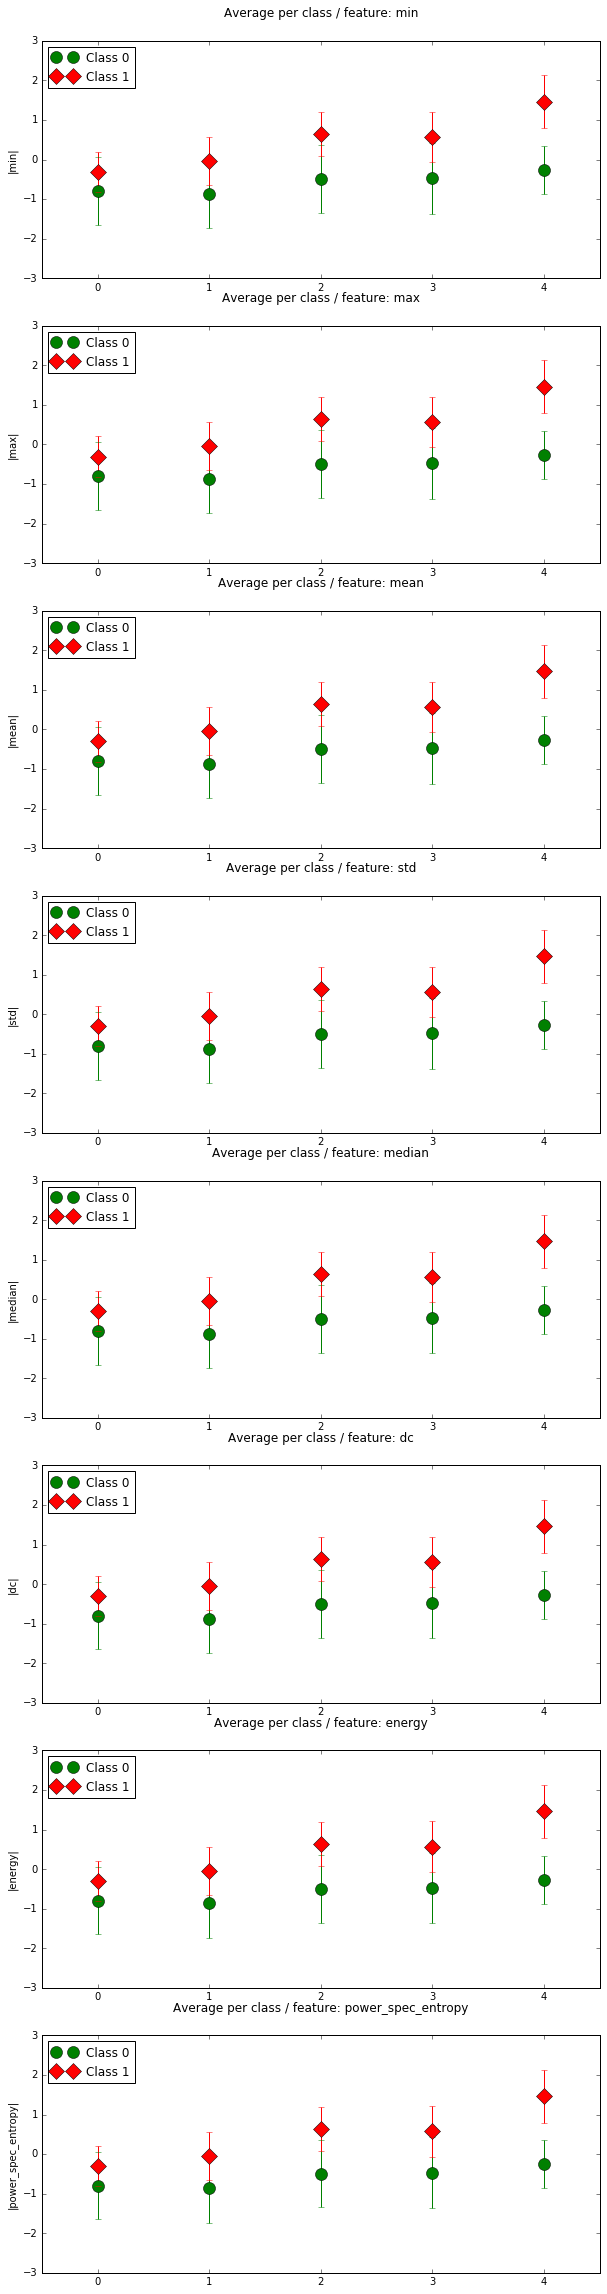

In [12]:
res = split_on_classes(train_data, train_labels)
num_of_windows = int(dta_dict["num_of_windows"])
feature_list = dta_dict["features"]
label_dicts = dta_dict["id_attributes"]

plot_one_feature_v3(res[0], res[1], num_of_windows, [0, 1], features=feature_list, f_index=-1,  
                       p_legend=True, width=10, height=5)